In [1]:
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null

In [2]:
import os
import math
import datetime
from tqdm import tqdm 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras 

import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import defaultdict

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stopWordList=set(stopwords.words('english'))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df_train = pd.read_csv("sentiment_dataset_train.csv")
df_dev = pd.read_csv("sentiment_dataset_dev.csv")
df_test = pd.read_csv("sentiment_dataset_test.csv")
df = df_train

In [4]:
df_train.head()

,id,review,rating
0,0,Arrived about 10pm and check in was painless. ...,4
1,1,I checked in at 4pm even tough room was not re...,2
2,2,"I chose this hotel, as it was in a good locati...",2
3,3,"Great location, super close to shops & a 10min...",4
4,4,I was in the Sir Adam Hotel to visit a friend....,3


In [5]:
df_train.dtypes

id         int64
review    object
rating     int64
dtype: object

# Exploratory Data Analysis

### Check class distribution

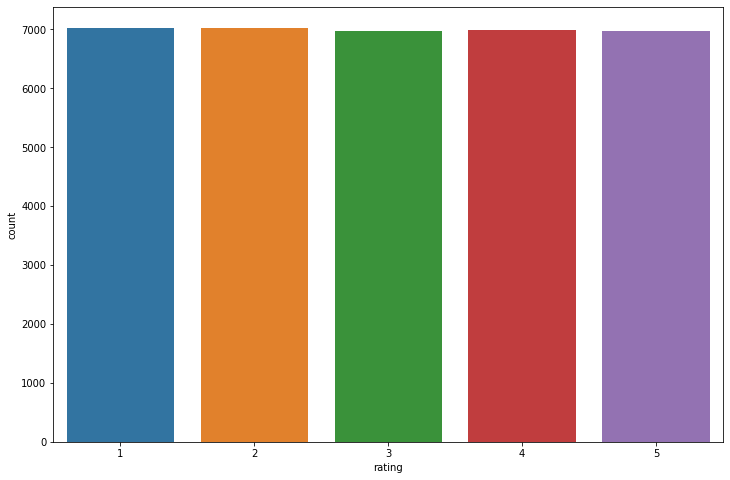

In [6]:
sns.countplot(x = df_train.rating)

The data seems to have equal distributions for each class (i.e., rating). This data is pretty well distruted among 5 classes. So, there is no issue with unbalanced class. 

### Check the length distribution of each category (rating)

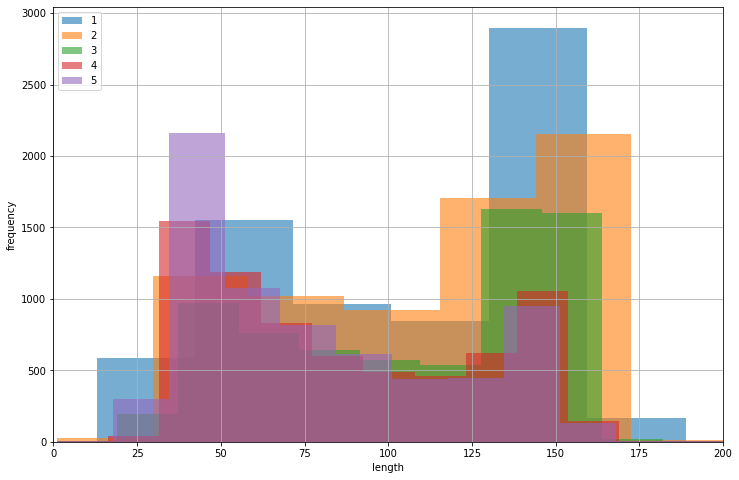

In [7]:
df_train['length'] = df_train['review'].str.split().apply(len)
bins = 30
plt.hist(df_train[df_train['rating'] == 1]['length'], alpha = 0.6, bins=bins, label='1')
plt.hist(df_train[df_train['rating'] == 2]['length'], alpha = 0.6, bins=bins, label='2')
plt.hist(df_train[df_train['rating'] == 3]['length'], alpha = 0.6, bins=bins, label='3')
plt.hist(df_train[df_train['rating'] == 4]['length'], alpha = 0.6, bins=bins, label='4')
plt.hist(df_train[df_train['rating'] == 5]['length'], alpha = 0.6, bins=bins, label='5')
plt.xlabel('length')
plt.ylabel('frequency')
plt.legend(loc='upper left')
plt.xlim(0,200)
plt.grid()
plt.show()


From the length distribution it seems like a large number of reviews either falls under the length of 30-60 words or 120-170 words.

### Visualizing Frequent words per category

In [8]:
def lemmatization(texts, allowed_postags=['ADJ', 'ADV']):
  '''
  Input: text corpus.
  Output: filtered corpus.
  This method filters the reviews and strips out everything other than the 
  adverbs and adjectives from the reviews and convert them to the 
  base form.
  '''
  texts_out = []
  for sent in texts:
      doc = nlp("".join(sent)) 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out

def create_corpus(df, label, topN):
  '''
  Input: dataframe, label, top N words
  Output: plot of the frequent words of specific label 
  This method srtips out the stop words from the corpus and takes the adjective
  and adverbs. Then it finds out the top frequent words from the corpus. 
  '''
  corpus=[]
  
  for x in df[df['rating']==label]['review'].str.split():
      for i in x:
          corpus.append(i)

  corpus_lem = lemmatization(corpus)

  dic=defaultdict(int)
  for word in corpus_lem:
    if word:
      if word[0].lower() not in stopWordList:
          dic[word[0]]+=1

  top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:topN]

  plt.rcParams['figure.figsize'] = (10.0, 6.0)
  x,y=zip(*top)
  plt.bar(x,y)
  plt.title('Top '+str(topN)+' frequent words in rating: '+ str(label))
  

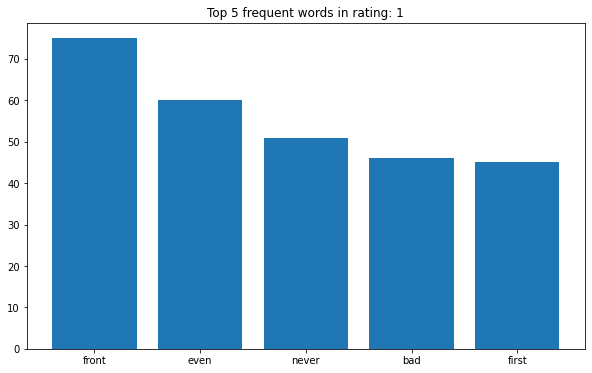

In [9]:
create_corpus(df_train[:1000], 1, 5)

As expected, the lowest rating has some mean words which has been seen more frequent in the reviews.

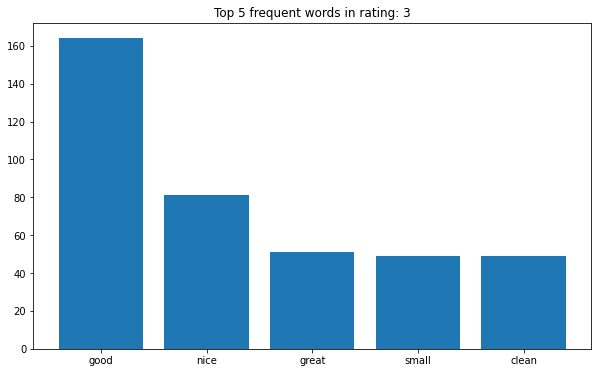

In [10]:
create_corpus(df_train[:1000], 3, 5)

This seems more neutral, kind of leaning towards positive.

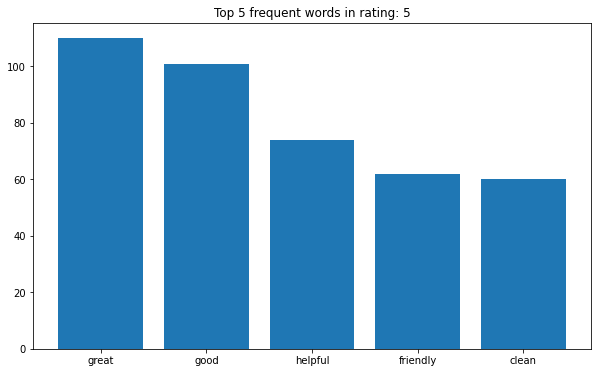

In [11]:
create_corpus(df_train[:1000], 5, 5)

The highest rated reviews seem to have more positive words such as great and good.

# Data Cleaning

In [12]:
def remove_stopWords(df, input_field, output_field):
  '''
  input: dataframe, input field name, output field name
  This method removes stop words from the corpus and add the processed texts 
  to the dataframe
  '''
  df[output_field] = df[input_field].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))

def remove_punctuations(df, input_field, output_field):
  '''
  input: dataframe, input field name, output field name
  This method removes punctuations from the corpus and add the processed texts 
  to the dataframe
  '''
  table=str.maketrans('','',string.punctuation)
  df[output_field]=df[input_field].apply(lambda x : x.translate(table))

def lemmatizer(text):
  '''
  input: text
  output: lemmatized text
  This method converts words to it's base form
  '''
  sent = []
  doc = nlp(text)
  for word in doc:
      sent.append(word.lemma_)
  return " ".join(sent)

### Convert the train-data

In [13]:
remove_stopWords(df_train, 'review', 'processed_review')
remove_punctuations(df_train, 'processed_review', 'processed_review')
df_train['processed_review']=df_train['processed_review'].apply(lambda x : lemmatizer(x))
df_train.to_csv('sentiment_processed_train.csv')

### Convert the dev-data 

In [14]:
remove_stopWords(df_dev, 'review', 'processed_review')
remove_punctuations(df_dev, 'processed_review', 'processed_review')
df_dev['processed_review']=df_dev['processed_review'].apply(lambda x : lemmatizer(x))
df_dev.to_csv('sentiment_processed_dev.csv')

### Convert the test-data

In [15]:
remove_stopWords(df_test, 'review', 'processed_review')
remove_punctuations(df_test, 'processed_review', 'processed_review')
df_test['processed_review']=df_test['processed_review'].apply(lambda x : lemmatizer(x))
df_test.to_csv('sentiment_processed_test.csv')

# Build Classification Model

### Baseline Model (Tf-Idf + Logistic Regression)

In [16]:
# Classificaiton metrics - precision, recall, f1, and accuracy
def get_metrics(y_test, y_predicted): 
  '''
  input: y_test, y_pred
  output: accuracy, precision, recall, f1
  This method calculates the performance of the model.
  '''
  # true positives / (true positives+false positives)
  precision = precision_score(y_test, y_predicted, pos_label=None,
                                  average='weighted')             
  # true positives / (true positives + false negatives)
  recall = recall_score(y_test, y_predicted, pos_label=None,
                            average='weighted')
  
  # harmonic mean of precision and recall
  f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
  
  # true positives + true negatives/ total
  accuracy = accuracy_score(y_test, y_predicted)
  return accuracy, precision, recall, f1

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
  '''
  input: y_true, y_pred, title, figsize
  This method plots the confusion matrix
  '''
  cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
      for j in range(ncols):
          c = cm[i, j]
          p = cm_perc[i, j]
          if i == j:
              s = cm_sum[i]
              annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
          elif c == 0:
              annot[i, j] = ''
          else:
              annot[i, j] = '%.1f%%\n%d' % (p, c)
  cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  fig, ax = plt.subplots(figsize=figsize)
  plt.title(title)
  sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [17]:
X_train = df_train['processed_review']
y_train = df_train['rating']
X_dev = df_dev['processed_review']
y_dev = df_dev['rating']
X_test = df_test['processed_review']

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)
X_test_tf_idf = tfidf_vectorizer.transform(X_test)

In [18]:
# Logistic Regression Model
model = LogisticRegression(class_weight='balanced', solver = 'lbfgs',n_jobs=-1, random_state=40)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_dev_tfidf)
train_pred_bow_int = y_pred.round().astype('int')

In [19]:
accuracy, precision, recall, f1 = get_metrics(y_dev, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.758 
precision = 0.759 
recall = 0.758 
f1 = 0.758


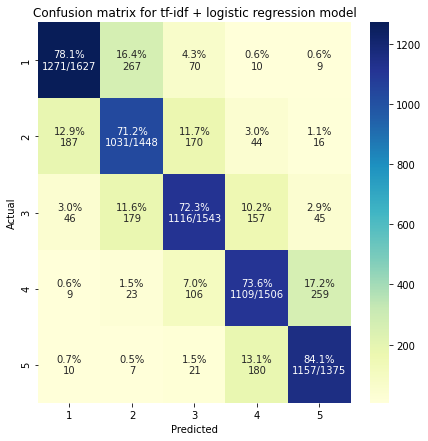

In [20]:
# Showing Confusion Matrix for bow model
plot_cm(train_pred_bow_int, y_dev, 'Confusion matrix for tf-idf + logistic regression model', figsize=(7,7))

### Perform prediction for the test data and save the model

In [21]:
y_pred_test = model.predict(X_test_tf_idf)

In [24]:
df_test['predicted_lr'] = y_pred_test
df_test.to_csv('sentiment_processed_test.csv')

In [33]:
import pickle
# save the classifier
with open('model_baseline.pkl', 'wb') as fid:
    pickle.dump(model, fid)  